In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
rom gensim.models import Word2Vec

import nltk


In [38]:
df=pd.read_csv('fakeReviewData.csv')
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [39]:
df.shape

(40432, 4)

In [40]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Checking Null Values

In [41]:
df.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

### Checking for duplicate values

In [42]:
print("duplicated values :",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("duplicated value after droping :",df.duplicated().sum())

duplicated values : 12
duplicated value after droping : 0


### Category Wise analysis

In [55]:
df['category'].value_counts()

category
Kindle_Store_5                  4728
Books_5                         4369
Pet_Supplies_5                  4251
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3944
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3847
Toys_and_Games_5                3792
Movies_and_TV_5                 3587
Name: count, dtype: int64

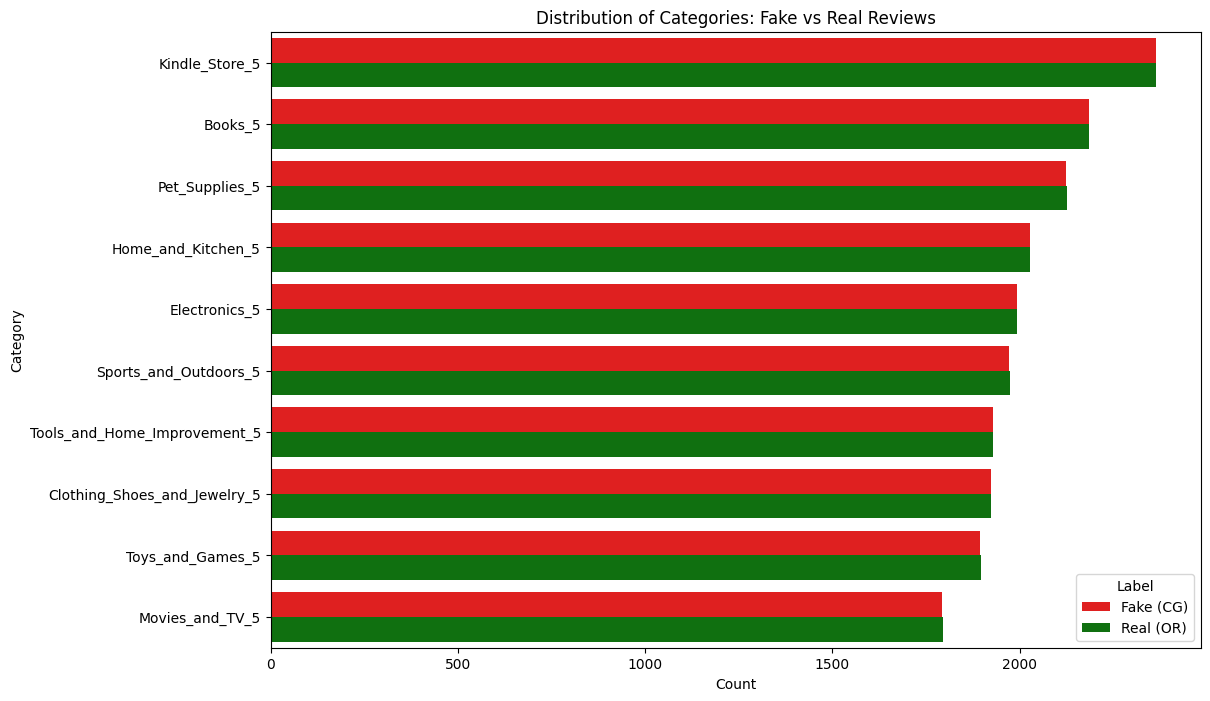

In [56]:
plt.figure(figsize=(12, 8))
sns.countplot(
    y='category',
    hue='label',
    data=df,
    order=df['category'].value_counts().index,
    palette={'CG': 'red', 'OR': 'green'}
)
plt.title('Distribution of Categories: Fake vs Real Reviews')
plt.xlabel('Count')
plt.ylabel('Category')
plt.legend(title='Label', labels=['Fake (CG)', 'Real (OR)'])
plt.show()


### Lable Wise Analysis

In [45]:
df['label'].value_counts()

label
OR    20215
CG    20205
Name: count, dtype: int64

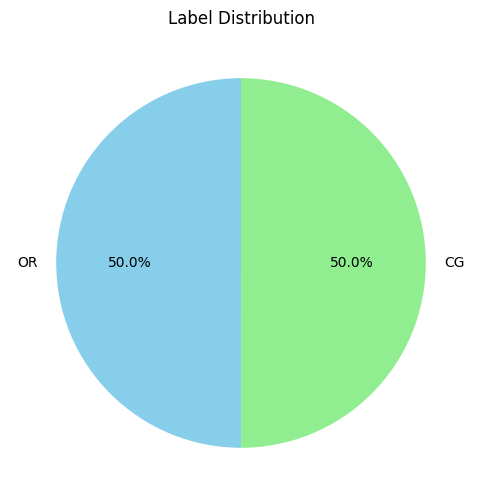

In [57]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(6, 6))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

### Rating Wise Analysis

In [58]:
df['rating'].value_counts()

rating
5.0    24547
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: count, dtype: int64

In [59]:
# Filter data by label
fake_reviews = df[df['label'] == 'CG']
real_reviews = df[df['label'] == 'OR']

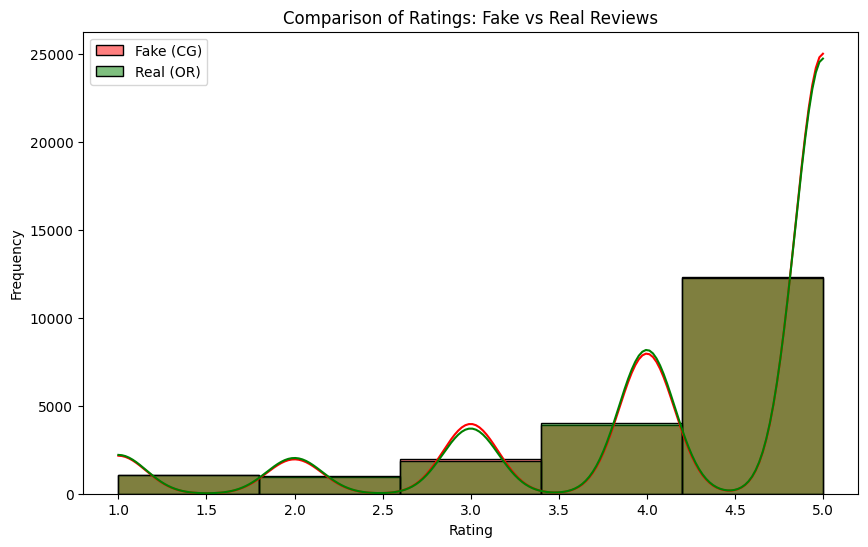

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(fake_reviews['rating'], bins=5, kde=True, color='red', label='Fake (CG)', alpha=0.5)
sns.histplot(real_reviews['rating'], bins=5, kde=True, color='green', label='Real (OR)', alpha=0.5)
plt.title('Comparison of Ratings: Fake vs Real Reviews')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Number of words in review

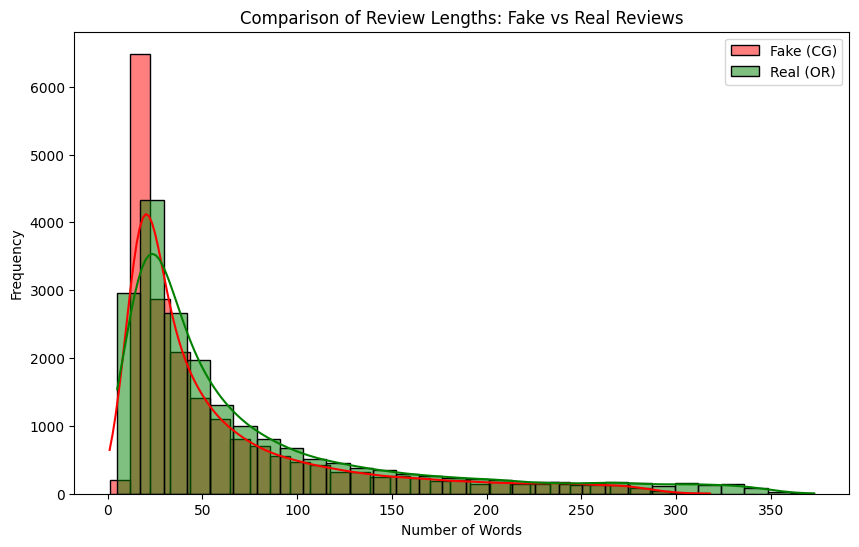

In [61]:
df['review_length'] = df['text_'].apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 6))
sns.histplot(fake_reviews['review_length'], bins=30, kde=True, color='red', label='Fake (CG)', alpha=0.5)
sns.histplot(real_reviews['review_length'], bins=30, kde=True, color='green', label='Real (OR)', alpha=0.5)
plt.title('Comparison of Review Lengths: Fake vs Real Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Preprocessing of data

### Text Preprocessing Function

The `preprocess(r)` function cleans and normalizes text data through several preprocessing steps, including:

1. **Convert to Lowercase**: The text is converted to lowercase and any leading/trailing spaces are removed.
  
2. **Replace Special Characters**: Special characters like `%`, `$`, `₹`, and `@` are replaced with their string equivalents (e.g., `₹` becomes `rupee`).

3. **Abbreviation Expansion**: Large numbers are shortened to their respective abbreviations like `k`, `m`, and `b` for thousands, millions, and billions.

4. **Contraction Expansion**: Common contractions like "I'm" and "can't" are expanded to their full forms (e.g., "I'm" becomes "I am").

5. **HTML Tag Removal**: HTML tags (e.g., `<tag>`) are removed using a regular expression.

6. **Remove Punctuation**: Non-alphanumeric characters (except spaces) are replaced with a space to clean the text.

This function helps prepare text data for NLP tasks, ensuring it is standardized and cleaned of unnecessary elements like special characters, HTML tags, and contractions.


In [62]:
import re

def preprocess(r):
    r = str(r).lower().strip()

    r = r.replace('%', ' percent')
    r = r.replace('$', ' dollar ')
    r = r.replace('₹', ' rupee ')
    r = r.replace('€', ' euro ')
    r = r.replace('@', ' at ')


    r = r.replace(',000,000,000 ', 'b ')
    r = r.replace(',000,000 ', 'm ')
    r = r.replace(',000 ', 'k ')
    r = re.sub(r'([0-9]+)000000000', r'\1b', r)
    r = re.sub(r'([0-9]+)000000', r'\1m', r)
    r = re.sub(r'([0-9]+)000', r'\1k', r)


    contractions = {
                "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
        "'ve": " have",
        "n't": " not",
        "'re": " are",
        "'ll": " will"

    }
        
    

    r_decontracted = []

    for word in r.split():
        if word in contractions:
            word = contractions[word]
        r_decontracted.append(word)

    r = ' '.join(r_decontracted)

 
    html_tag_pattern = re.compile(r'<.*?>')
    r = re.sub(html_tag_pattern, '', r)


    pattern = re.compile('\W')
    r = re.sub(pattern, ' ', r).strip()

    return r


<>:162: SyntaxWarning: invalid escape sequence '\W'
<>:162: SyntaxWarning: invalid escape sequence '\W'
C:\Users\krish\AppData\Local\Temp\ipykernel_21484\3944021458.py:162: SyntaxWarning: invalid escape sequence '\W'
  pattern = re.compile('\W')


In [64]:
df['text_'] = df['text_'].apply(preprocess)
df.rename(columns={'text_': 'review'}, inplace=True)
df


,category,rating,label,review,review_length
0,Home_and_Kitchen_5,5.0,CG,love this well made sturdy and very comfort...,12
1,Home_and_Kitchen_5,5.0,CG,love it a great upgrade from the original i ...,16
2,Home_and_Kitchen_5,5.0,CG,this pillow saved my back i love the look and...,14
3,Home_and_Kitchen_5,1.0,CG,missing information on how to use it but it i...,17
4,Home_and_Kitchen_5,5.0,CG,very nice set good quality we have had the s...,18
...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,i had read some reviews saying that this bra r...,329
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,i was not sure exactly what it would be it is...,270
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,you can wear the hood by itself wear it with ...,343
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,i liked nothing about this dress the only rea...,278


### Tokenization and Stopword Removal

In this code, I tokenize the reviews and remove stopwords using NLTK:

1. **Tokenization**: I use `word_tokenize()` to break the review text into individual words and convert everything to lowercase for consistency.
2. **Stopword Removal**: I filter out common stopwords (like 'the', 'is', etc.) and non-alphabetic words (such as punctuation) to keep only meaningful words.
3. **Applied to Data**: The `tokenize_and_remove_stopwords()` function is applied to the `review` column to process all the reviews in the dataset.

This helps in preparing the data for further analysis or model training by focusing on important words.


In [65]:
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text.lower())  
    
   
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalpha() and word not in stop_words]  
    
    return words



df['tokenized_review'] = df['review'].apply(tokenize_and_remove_stopwords)

# Show the first few rows of the dataframe with the tokenized review column
df[['review', 'tokenized_review']].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,tokenized_review
0,love this well made sturdy and very comfort...,"[love, well, made, sturdy, comfortable, love, ..."
1,love it a great upgrade from the original i ...,"[love, great, upgrade, original, mine, couple,..."
2,this pillow saved my back i love the look and...,"[pillow, saved, back, love, look, feel, pillow]"
3,missing information on how to use it but it i...,"[missing, information, use, great, product, pr..."
4,very nice set good quality we have had the s...,"[nice, set, good, quality, set, two, months]"


### Lemmatization

The code performs lemmatization on the tokenized reviews:

1. **Lemmatization**: The `WordNetLemmatizer` from NLTK is used to convert words to their base or root form (e.g., "running" becomes "run").
   
2. **Apply Lemmatization**: The `lemmatize_words_in_list()` function is applied to the `tokenized_review` column to lemmatize each word in the tokenized reviews.

3. **Drop Columns**: After lemmatization, the original `tokenized_review` and `review` columns are dropped, leaving only the lemmatized reviews for further analysis.

This step helps in reducing words to their canonical form, improving the quality of data for tasks like text classification or sentiment analysis.



In [69]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words_in_list(tokenized_text):
    return [lemmatizer.lemmatize(word) for word in tokenized_text]
df['tokenized_lammatized_review']=df['tokenized_review'].apply(lemmatize_words_in_list)
df.drop(columns=['tokenized_review','review'],inplace=True)

In [70]:
df

,category,rating,label,review_length,tokenized_lammatized_review
0,Home_and_Kitchen_5,5.0,CG,12,"[love, well, made, sturdy, comfortable, love, ..."
1,Home_and_Kitchen_5,5.0,CG,16,"[love, great, upgrade, original, mine, couple,..."
2,Home_and_Kitchen_5,5.0,CG,14,"[pillow, saved, back, love, look, feel, pillow]"
3,Home_and_Kitchen_5,1.0,CG,17,"[missing, information, use, great, product, pr..."
4,Home_and_Kitchen_5,5.0,CG,18,"[nice, set, good, quality, set, two, month]"
...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,329,"[read, review, saying, bra, ran, small, ordere..."
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,270,"[sure, exactly, would, little, large, small, s..."
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,343,"[wear, hood, wear, hood, wear, jacket, without..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,278,"[liked, nothing, dress, reason, gave, star, or..."


### Word2Vec Model and Sentence Vectorization

This code performs the following steps to generate sentence embeddings using Word2Vec:

1. **Tokenized Reviews**: The tokenized and lemmatized reviews are extracted into a list (`tl_reviews`) from the `tokenized_lammatized_review` column of the DataFrame.

2. **Train Word2Vec Model**: A Word2Vec model is trained using the `tl_reviews` list. The model generates 300-dimensional word vectors, using a context window of 5 and a minimum word frequency of 1. The training process builds a vocabulary from the tokenized reviews.

3. **Sentence Vectorization**: The `get_sentence_vector()` function is defined to convert each review into a vector by averaging the word vectors of the words that appear in the review. If no words in the review are present in the Word2Vec model, a zero vector is returned.

4. **Apply Sentence Vectorization**: The `get_sentence_vector()` function is applied to all tokenized reviews to create corresponding sentence vectors.

5. **Create DataFrame for Vectors**: A DataFrame (`vector_df`) is created, where each sentence vector is broken into 300 columns (each representing a dimension of the vector).

6. **Concatenate Vectors to Original DataFrame**: The sentence vectors are concatenated to the original DataFrame, providing a feature representation for each review.

This method generates numerical vector representations for each review, which can be used as input for machine learning models.


In [72]:
tl_reviews = df['tokenized_lammatized_review'].tolist()
word2vec_model = Word2Vec(sentences=tl_reviews, vector_size=300, window=5, min_count=1, workers=4)


def get_sentence_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)

sentence_vectors = np.array([get_sentence_vector(review, word2vec_model) for review in tl_reviews])

vector_columns = [f'vector_{i}' for i in range(300)]
vector_df = pd.DataFrame(sentence_vectors, columns=vector_columns)

df = pd.concat([df.reset_index(drop=True), vector_df], axis=1)
df



,category,rating,label,review_length,tokenized_lammatized_review,vector_0,vector_1,vector_2,vector_3,vector_4,...,vector_290,vector_291,vector_292,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299
0,Home_and_Kitchen_5,5.0,CG,12,"[love, well, made, sturdy, comfortable, love, ...",-0.804590,0.481191,-0.285825,-0.462772,0.739007,...,-0.255275,-0.648876,-0.052210,-0.783662,1.084464,-0.123554,-0.704803,0.646641,-0.282995,0.130236
1,Home_and_Kitchen_5,5.0,CG,16,"[love, great, upgrade, original, mine, couple,...",-0.486222,0.256368,-0.294677,-0.397469,0.389246,...,0.296213,-0.189238,-0.200795,-0.190147,0.508693,0.264778,-0.258132,0.208602,-0.045064,-0.021818
2,Home_and_Kitchen_5,5.0,CG,14,"[pillow, saved, back, love, look, feel, pillow]",-0.387456,0.229464,-0.055881,-0.367134,0.287254,...,-0.153325,-0.577915,-0.207084,-0.582206,0.119856,-0.091124,-0.414107,0.225461,0.070679,0.243602
3,Home_and_Kitchen_5,1.0,CG,17,"[missing, information, use, great, product, pr...",-0.740298,0.389238,-0.277272,-0.528126,0.380181,...,0.037694,-0.022883,-0.209844,-0.144074,0.555826,-0.047700,-0.497539,-0.160150,-0.217373,-0.212763
4,Home_and_Kitchen_5,5.0,CG,18,"[nice, set, good, quality, set, two, month]",-0.632959,0.683162,-0.519207,-0.979485,0.759243,...,0.179084,-0.433039,-0.780914,-0.108497,0.912606,0.210082,-0.706816,0.253343,-0.477278,0.214335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40415,Clothing_Shoes_and_Jewelry_5,4.0,OR,329,"[read, review, saying, bra, ran, small, ordere...",-0.305547,0.316302,-0.366049,-0.225891,0.091252,...,0.034941,-0.074553,-0.184669,0.004718,0.474189,0.442348,-0.270068,0.096329,-0.080766,-0.239213
40416,Clothing_Shoes_and_Jewelry_5,5.0,CG,270,"[sure, exactly, would, little, large, small, s...",-0.488439,0.596582,-0.481716,-0.562213,0.297560,...,-0.011763,-0.359533,-0.175007,-0.245164,0.858082,0.367363,-0.463109,0.182412,-0.265567,-0.275691
40417,Clothing_Shoes_and_Jewelry_5,2.0,OR,343,"[wear, hood, wear, hood, wear, jacket, without...",-0.262224,0.127307,-0.243494,-0.216813,0.066088,...,-0.007831,-0.138087,-0.093576,-0.085409,0.294199,0.260262,-0.168936,0.025921,-0.032457,-0.119078
40418,Clothing_Shoes_and_Jewelry_5,1.0,CG,278,"[liked, nothing, dress, reason, gave, star, or...",-0.413996,0.601449,-0.472156,-0.622944,0.307277,...,0.000898,-0.401374,-0.225263,-0.394116,0.893934,0.330103,-0.484414,0.297184,-0.230786,-0.264657


### One-Hot Encoding for Categorical Column

This code performs One-Hot Encoding on the categorical column `category` in the DataFrame. The steps are as follows:

1. **Initialize OneHotEncoder**: The `OneHotEncoder` from `sklearn.preprocessing` is initialized with `sparse_output=False` to return dense arrays instead of sparse matrices. This ensures that the encoded values are returned as a regular NumPy array.

2. **Fit and Transform**: The encoder is then applied to the `category` column, which is a categorical column in the DataFrame. The `.fit_transform()` method is used to learn the encoding and apply it to the data.

3. **Create DataFrame for Encoded Features**: A new DataFrame `encoded_df` is created where the columns correspond to the unique categories in the `category` column, and each row contains a one-hot encoded vector representing the category for that review.

4. **Concatenate with Original DataFrame**: The original DataFrame `df` is updated by concatenating the one-hot encoded features with the existing data, ensuring that the original DataFrame retains the non-categorical features along with the new one-hot encoded columns.

This process transforms categorical data into a numerical format that can be used in machine learning algorithms.


In [73]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

categorical_columns = df[['category']]
encoded_features = encoder.fit_transform(categorical_columns)

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(categorical_columns.columns)
)


df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)


df

,category,rating,label,review_length,tokenized_lammatized_review,vector_0,vector_1,vector_2,vector_3,vector_4,...,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
0,Home_and_Kitchen_5,5.0,CG,12,"[love, well, made, sturdy, comfortable, love, ...",-0.804590,0.481191,-0.285825,-0.462772,0.739007,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Home_and_Kitchen_5,5.0,CG,16,"[love, great, upgrade, original, mine, couple,...",-0.486222,0.256368,-0.294677,-0.397469,0.389246,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Home_and_Kitchen_5,5.0,CG,14,"[pillow, saved, back, love, look, feel, pillow]",-0.387456,0.229464,-0.055881,-0.367134,0.287254,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Home_and_Kitchen_5,1.0,CG,17,"[missing, information, use, great, product, pr...",-0.740298,0.389238,-0.277272,-0.528126,0.380181,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Home_and_Kitchen_5,5.0,CG,18,"[nice, set, good, quality, set, two, month]",-0.632959,0.683162,-0.519207,-0.979485,0.759243,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40415,Clothing_Shoes_and_Jewelry_5,4.0,OR,329,"[read, review, saying, bra, ran, small, ordere...",-0.305547,0.316302,-0.366049,-0.225891,0.091252,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40416,Clothing_Shoes_and_Jewelry_5,5.0,CG,270,"[sure, exactly, would, little, large, small, s...",-0.488439,0.596582,-0.481716,-0.562213,0.297560,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40417,Clothing_Shoes_and_Jewelry_5,2.0,OR,343,"[wear, hood, wear, hood, wear, jacket, without...",-0.262224,0.127307,-0.243494,-0.216813,0.066088,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40418,Clothing_Shoes_and_Jewelry_5,1.0,CG,278,"[liked, nothing, dress, reason, gave, star, or...",-0.413996,0.601449,-0.472156,-0.622944,0.307277,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lable encoding of lable coloumn

In [74]:
df['label_encoded'] = df['label'].map({'CG': 1, 'OR': 0})


In [75]:
preprocessed_df=df.drop(columns=['category','tokenized_lammatized_review','label'])

In [76]:
preprocessed_df

,rating,review_length,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5,label_encoded
0,5.0,12,-0.804590,0.481191,-0.285825,-0.462772,0.739007,-0.971841,0.576671,1.100340,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5.0,16,-0.486222,0.256368,-0.294677,-0.397469,0.389246,-0.303876,0.094688,0.796677,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5.0,14,-0.387456,0.229464,-0.055881,-0.367134,0.287254,-0.609241,0.487347,0.760885,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,17,-0.740298,0.389238,-0.277272,-0.528126,0.380181,-0.261334,-0.049729,0.928828,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5.0,18,-0.632959,0.683162,-0.519207,-0.979485,0.759243,-0.340919,0.137742,1.307219,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40415,4.0,329,-0.305547,0.316302,-0.366049,-0.225891,0.091252,-0.080977,0.316878,0.726755,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
40416,5.0,270,-0.488439,0.596582,-0.481716,-0.562213,0.297560,-0.510229,0.280542,0.753424,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
40417,2.0,343,-0.262224,0.127307,-0.243494,-0.216813,0.066088,-0.210621,0.272817,0.571335,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
40418,1.0,278,-0.413996,0.601449,-0.472156,-0.622944,0.307277,-0.514050,0.458349,0.760008,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Saving Preprocessed Data

In [79]:
preprocessed_df.to_csv('preprocessed_data.csv', index=False)